In [9]:
import numpy as np 
import matplotlib.pyplot as plt



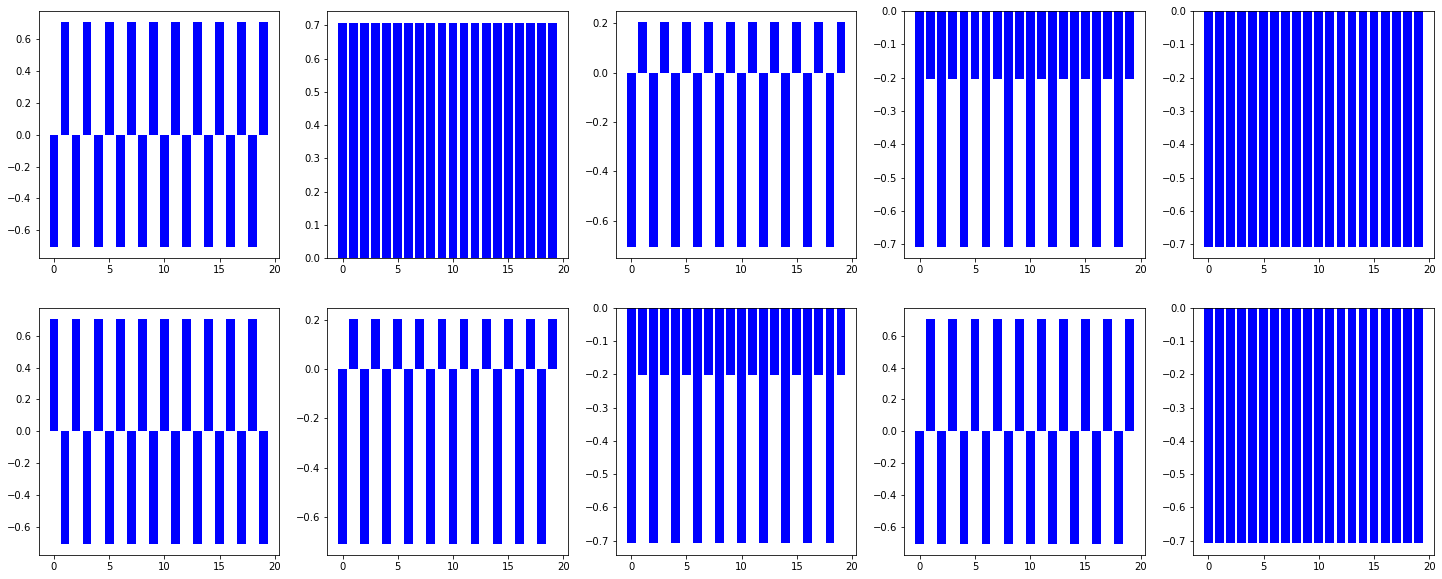

In [10]:
def is_even(n):
    return n//2 * 2 == n

# define the SSH hamiltonian
def ssh_finite(v,w, N):
    # need N to be even
    if not is_even(N):
        raise Exception("N must be even")

    # Create the matrix
    mat = np.zeros((N, N))
    
    for k in range(0,N//2):
        i = 2 * k
        mat[i][i+1] = v
        mat[i+1][i] = v
        if i + 2 < N:
            mat[i+1][i+2] = w
            mat[i+2][i+1] = w
    
    # Compute eigenvectors
    eigs, vecs = np.linalg.eigh(mat)
    return eigs, vecs.T

def ssh_bulk(v, w, N):
    # Compute the spacings for the wave number
    k_range = np.linspace(0,2 *np.pi, N//2)

    # Compute the eigenvalues and eigenvectors for a specific wave numebr
    def k_eigs(k):
        mat = np.array([
            [0, v + w * np.exp(-1j*k)],
            [v + w * np.exp(1j*k),0]
        ])

        return np.linalg.eigh(mat)

    # Compute all eigenvalues and vectors
    eigs = []
    evecs = []
    for k in k_range:
        eig, vecs = k_eigs(k)

        eigs += list(eig)
        evecs += list(vecs.T)

    return np.array(eigs), np.array(evecs)

# Eigenvector plotting
# splits into +ve negative eigenvectors
def plot_eigs(eigs):
    p_eigs = np.sort(eigs[eigs>0])
    n_eigs = np.sort(eigs[eigs<0])[::-1]

    plt.plot(p_eigs)
    plt.plot(n_eigs)

# Plots an eigenvector
def plot_eigvec(vec, y_scale=0.5):
    plt.ylim(-y_scale, y_scale)
    plt.bar(list(range(0,len(vec))),vec)

def plot_periodic_eigvec(vec, N=10):
    l = len(vec)
    for i in range(0, N):
        plt.bar(list(range(i * l, (i+1) * l)), vec, color='blue')

plt.figure(figsize=(25,10))
for i in range(0,10):
    plt.subplot(2,5,i + 1)      
    plot_periodic_eigvec(ssh_bulk(0.3,1,10)[1][i])

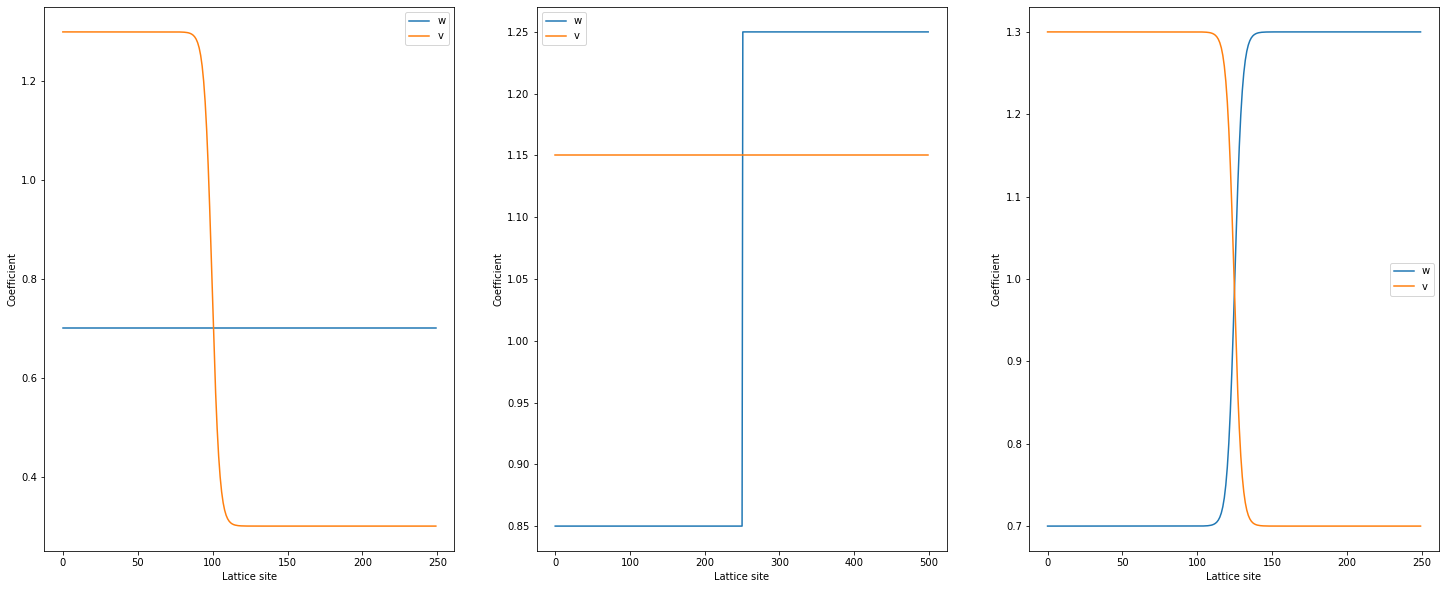

In [62]:
# Define the toy model hamiltonian

def toy_finite(v, N, epsilon, invert=False):
    # need N to be even
    if not is_even(N):
        raise Exception("N must be even")

    mat = np.zeros((N,N))
    for k in range(0,N//2):
        i = 2 * k
        mat[i][i+1] = v(i, epsilon, invert=invert)
        mat[i+1][i] = v(i, epsilon, invert=invert)
        if i + 2 < N:
            mat[i+1][i+2] = v(i+1, epsilon, invert=invert)
            mat[i+2][i+1] = v(i+1, epsilon, invert=invert)

    # Compute eigenvectors
    eigs, vecs = np.linalg.eigh(mat)
    return eigs, vecs.T

def linear_perturbation(N, start=0, end=1, base_size=0.1):
    def v(i, epsilon, invert=False):
        return 1 + (-1)**(i+invert) * (epsilon * i * (end - start)/ N + base_size)

    return v

def tanh_perturbation(N, rate=0.1, base_size=0.3):
    def v(i, epsilon, invert=False):
        if is_even(i + 1 - invert):
            return 1 +  epsilon * (np.tanh((i - N//2) * rate) + 1) + base_size
        return 1 - epsilon * (np.tanh((i - N//2) * rate) + 1) - base_size
    
    return v


def tanh_single_perturbation(N, rate=0.1, base_size=0.3):
    def v(i, epsilon, invert=False):
        if is_even(i + 1 - invert):
            return 1 +  epsilon * (np.tanh((i - N//2 + 50) * rate) + 1) + base_size
        return 1 - base_size
    
    return v

def discrete_single_perturbation(N, rate=0.1, base_size=0.15):
    def v(i, epsilon, invert=False):
        if i > N//2:
            if is_even(i-invert):
                return 1 - epsilon - base_size
            return 1 + base_size
        return 1 + (-1)**(i+1+invert) * base_size
    
    return v

def discrete_perturbation(N, base_size=0.15):
    def v(i, epsilon, invert=False):
        if i > N//2:
            return 1 + (-1)**(i+1+invert) *(epsilon + base_size)
        return 1 + (-1)**(i+1+invert) * base_size
    
    return v

def uniform_perturbation(base, base_size=0.1):
    def v(i, epsilon, invert=False):
        return base + (-1)**(i+1 - invert) * (epsilon + base_size)
    
    return v

def plot_pert(perturbation, N, epsilon=0.3):
    r = list(range(0,N//2))
    w = []
    v = []

    for i in range(0,N):
        if is_even(i):
            w.append(perturbation(i, epsilon))
        else:
            v.append(perturbation(i, epsilon))


    plt.xlabel("Lattice site")
    plt.ylabel("Coefficient")

    plt.plot(list(range(0,len(w))), w, label='w')
    plt.plot(list(range(0,len(v))), v, label='v')
    plt.legend()

plt.figure(figsize=(25,10))
plt.subplot(131)
plot_pert(tanh_single_perturbation(500),500, epsilon=-.5)
plt.subplot(132)
plot_pert(discrete_single_perturbation(1000),1000, epsilon=-0.4)
plt.subplot(133)
plot_pert(tanh_perturbation(500),500, epsilon=-0.3)

# plot_eigs(toy_finite(tanh_perturbation(100),100)[0])
# plot_eigs(ssh_finite(1.0,1.0,100)[0])


In [91]:
# Now introduce time dependent polarization computations, this involves slowly turning on the perturbation (epsilon 0 -> e)
# We can use the previously defined toy model to compute the instantaneous eigenvectors/values

def toy_finite_hamiltonian(perturbation, N):
    # epsilon determines the size of the perturbation, invert determines if the parameters should be swapped or not
    # Ie for a two band bulk insulator switching between the topological and trivial modes
    def H(epsilon, invert=False):
        return toy_finite(perturbation, N, epsilon, invert=invert)
    
    return H

# Compute the right charge operator expectation
def right_charge(a, v):
    # Formally Q is a matrix of size N * N with 1's on the diagonal for indicies i >= a else 0
    # So its the following inner product
    return np.vdot(v[a:], v[a:])

# Compute the current contribution from each eigenvector at each timestep
def single_eig_current(H, N, min_e = 0, max_e = 0.9, timesteps=100):
    # Compute all eigenvectors for each step 
    vecs = []
    eigs = []
    epsilon_step = (max_e - min_e)/timesteps
    for t in range(0, timesteps):
        t_eigs, t_vecs = H(t * epsilon_step)

        vecs.append(t_vecs)
        eigs.append(t_eigs)
    
    vecs = np.array(vecs)
    eigs = np.array(eigs)

    # Now compute the gradients of the vecs across the timesteps
    vec_grads = np.gradient(vecs)[0]

    currents = np.zeros((N, timesteps, N))

    for a in range(0, N):
        for t in range(0, timesteps):
            vec_grads_t = vec_grads[t]
            vecs_t = vecs[t]
            for n in range(0, N):
                # This neglects the rate parameter d_t lambda which cancels in the final integral
                currents[a,t,n] = -right_charge(a, vecs_t[n], vec_grads_t[n]) - right_charge(a, vec_grads_t[n], vecs_t[n])
                
    return currents

# Compute the explicit polarization induced by the occupied states
def local_polarization(H, N, min_e=0, max_e=0.1, states=None, invert=False):
    # compute the eigenstates of the system at the start and end of the perturbative change
    # here we only consider perturbations which do not close the band gap
    s_eigs, s_vecs = H(min_e, invert=invert)
    e_eigs, e_vecs = H(max_e, invert=False)

    # If states==None we assume that the model has two energy bands and only the negative one is occupied
    # If both bands are occupied then the total polarization will cancel
    if states == None:
        states = np.arange(0,N)[e_eigs <= 0]
    
    # Compute the contribution from each eigenstate
    polarizations = np.zeros(N)

    b = []
    r = []

    for a in range(0,N):
        b.append(0)
        r.append(0)
        for n in states:
            b[a] += right_charge(a, s_vecs[n])
            r[a] += right_charge(a, e_vecs[n])
            polarizations[a] += right_charge(a, s_vecs[n]) - right_charge(a, e_vecs[n])
        
    print("b", np.sum(b))
    print("r", np.sum(r))
    return polarizations

# Code berry phase polarization tomorrow, see if the issue is still present then and if it is then we know that we are understanding it wrong
# If there is no issue then we have something incorrect about our assumptions in computing the local polarization and need to approach it differently (not ideal)
def plot_pert_polarizations(H, N, min_e=0, max_e=0.5, row_num=4, col_num=5):
    plt.figure(figsize=(20,15))
    tot = row_num * col_num
    rate = (max_e - min_e) / tot
    for i in range(0,tot):
        plt.subplot(row_num, col_num, i + 1)
        plt.ylim(-1,1)
        p = local_polarization(H, N, min_e=0,max_e=rate * (i+1), invert=False)
        plt.plot(np.arange(0,N), p, label="Epsilon: %.2f" % rate * (i+1))
        print(np.mean(p))
        plt.xlabel(rate * (i+1))



In [69]:
def plot_pert_polarizations_range(H, N, min_e=0, max_e=-0.6, num=100):
    rate = (max_e - min_e) / num
    pols = []
    local_pols = []
    for i in range(0, num):
        p = local_polarization(H, N, min_e=0, max_e= rate * (i+1), invert=False)
        local_pols.append(p)
        pols.append(np.average(p))
    
    return pols, local_pols

pols, local_pols = plot_pert_polarizations_range(toy_finite_hamiltonian(tanh_single_perturbation(500),500),500, num=200)

b 62873.68333333335
r 62873.623930889655
0.00011880488738883384
b 62873.68333333335
r 62873.54867021277
0.0002693262411816099
b 62374.50000000002
r 62374.73269230768
-0.0004653846153424538
b 62873.68333333335
r 62873.31830808081
0.0007300505050866416
b 62374.50000000002
r 62375.052450980394
-0.0011049019607416875
b 62374.50000000002
r 62375.336585365854
-0.0016731707316899806
b 62873.68333333335
r 62872.36874120957
0.0026291842475542867
b 62873.68333333335
r 62871.405263157896
0.0045561403509122925
b 62873.68333333335
r 62868.498059368
0.010370547930698137
b 62873.68333333335
r 62802.1143967703
0.1431378731260949
b 62374.50000000002
r 62514.17322251601
-0.27934644503196787
b 62873.68333333335
r 62730.2217126239
0.28692324141891795
b 62374.50000000002
r 62519.585569922136
-0.2901711398442266
b 62873.68333333335
r 62727.59268548956
0.29218129568758067
b 62873.68333333335
r 62726.8704347685
0.2936257971296995
b 62374.50000000002
r 62521.875019263025
-0.2947500385260034
b 62374.50000000002

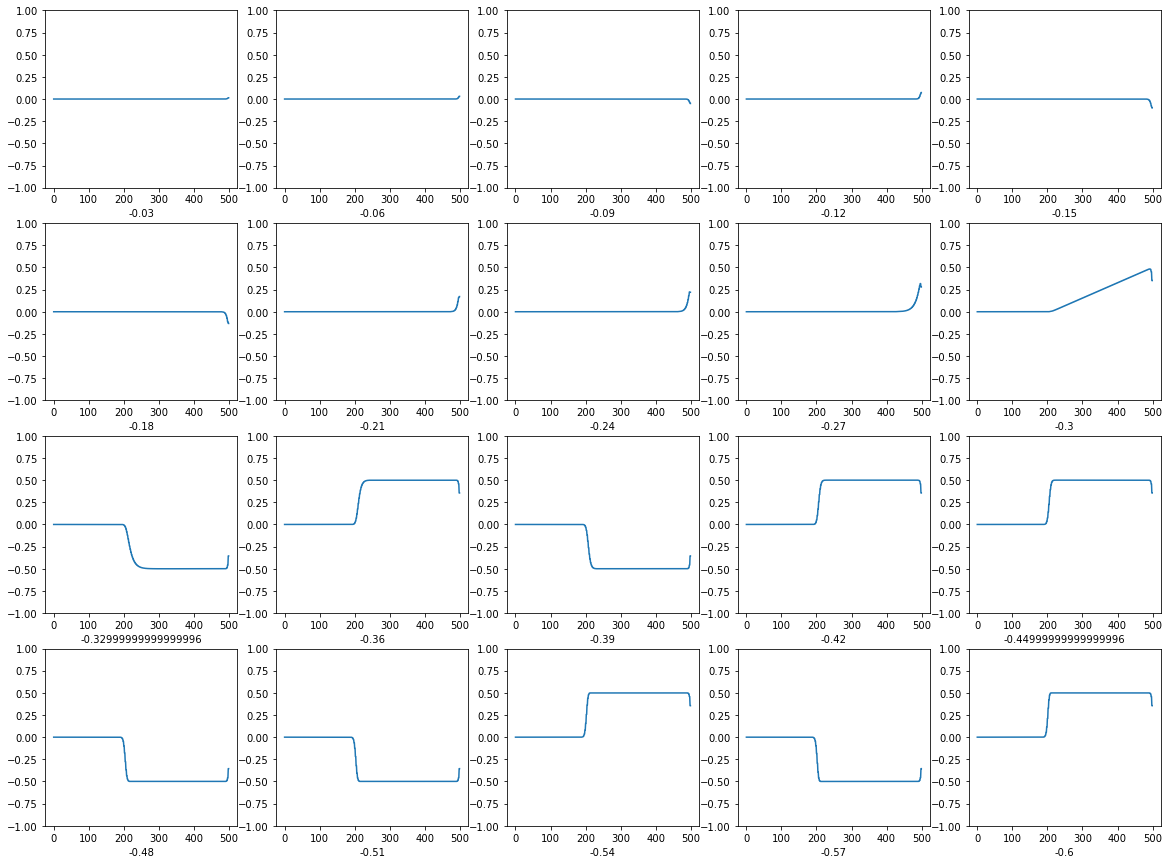

In [92]:
plot_pert_polarizations(toy_finite_hamiltonian(tanh_single_perturbation(500),500),500, max_e=-0.6)

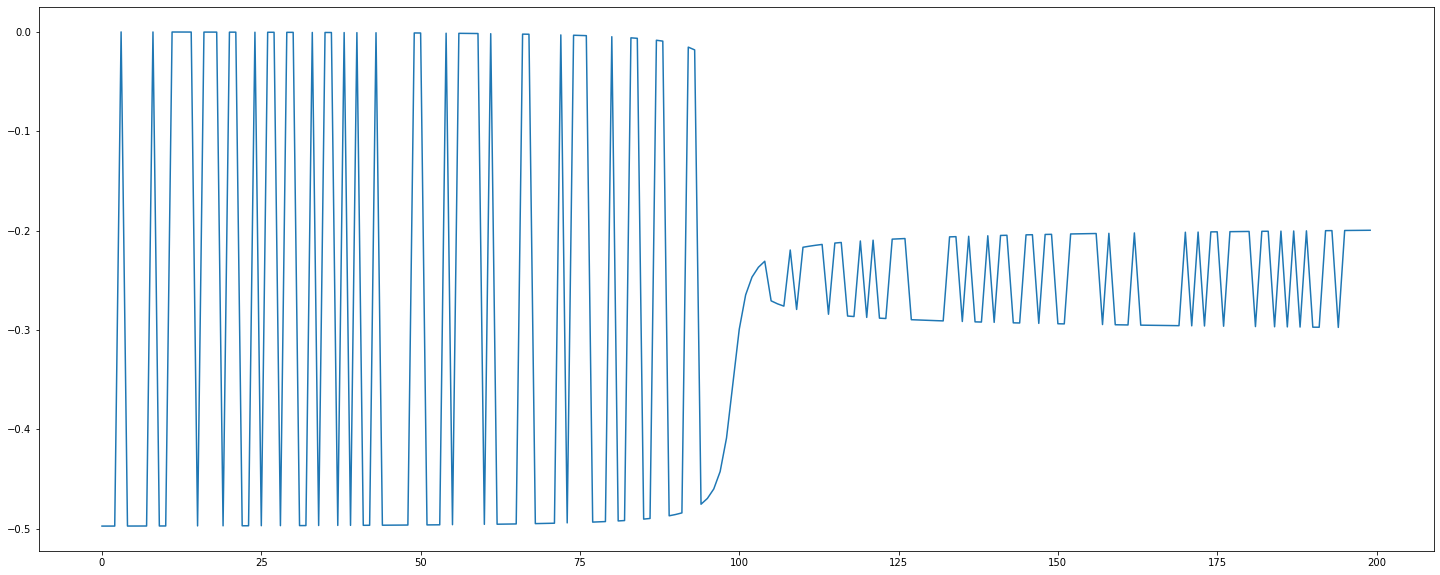

In [70]:
plt.figure(figsize=(25,10))
plt.plot(np.arange(0,200), pols)
# Idea, as the change occurs for very small values of epsilon we should be able to use perturbation theory to arrive at a result 
# This could be that this change is functioning as a charge pump

In [82]:
N=3000
H = toy_finite_hamiltonian(tanh_perturbation(N), N)

def plot_perturbed_eigenvectors(H, epsilon, row_num=2, col_num=4, invert=False):
    eigs, vecs = H(epsilon, invert=invert)
    plt.figure(figsize=(25,10))
    j=1
    for i in [0,1,2,3,500//2 , 500//2 +1,498,499]:
        plt.subplot(row_num,col_num,j)
        j+=1
        plot_eigvec(vecs[i])
        plt.xlabel(eigs[i])

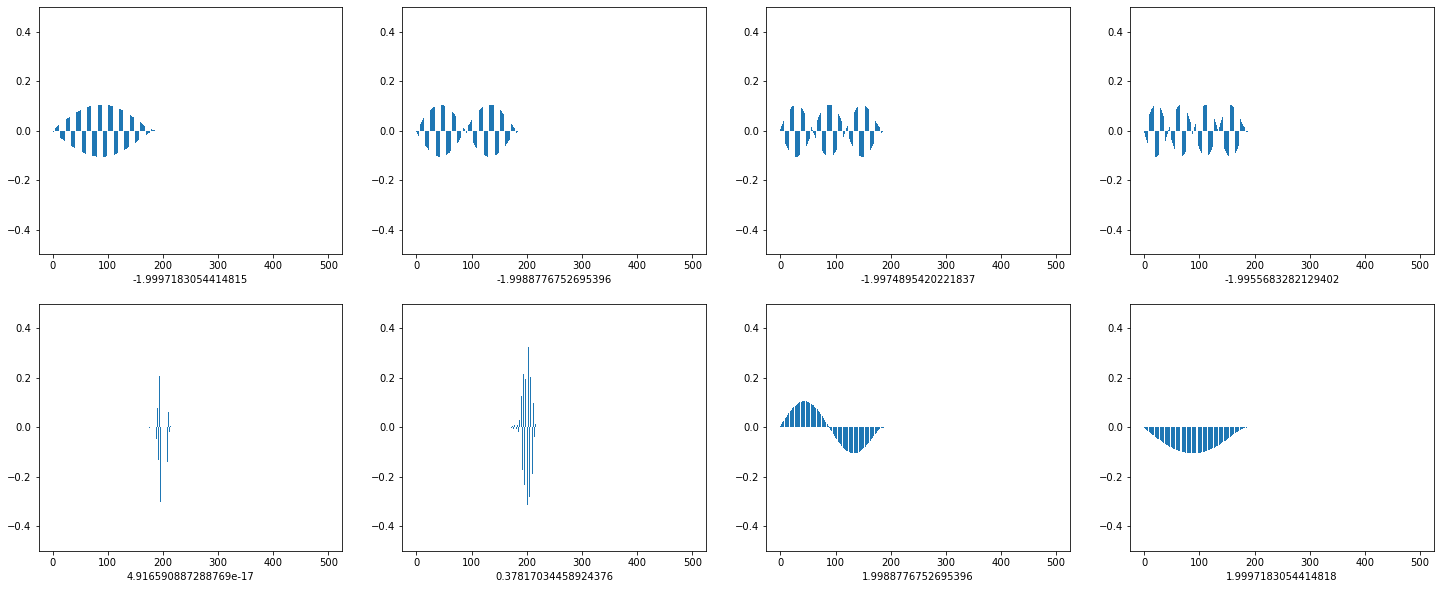

In [83]:
H_2 = toy_finite_hamiltonian(tanh_single_perturbation(500), 500)
plot_perturbed_eigenvectors(H_2, -0.6, invert=True)
# eigs_a, _ = H(-.1, invert=True)
# eigs_b, _ = H(-.1, invert=False)

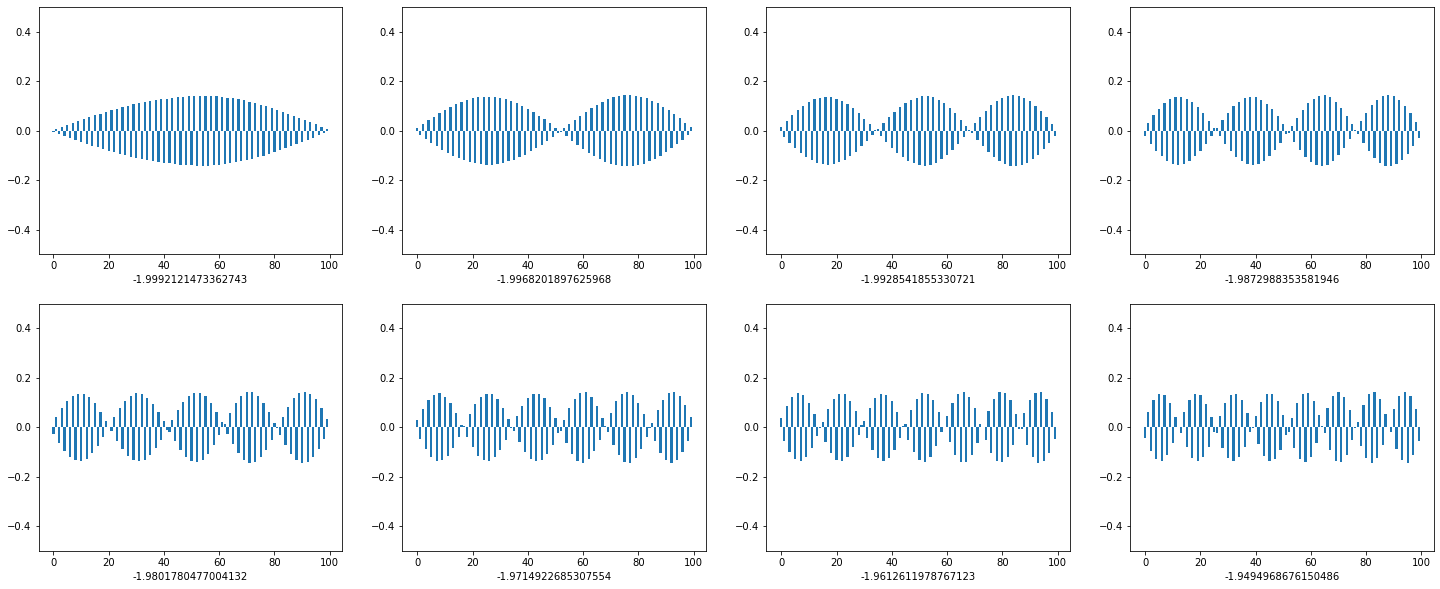

In [190]:
H_2 = toy_finite_hamiltonian(tanh_perturbation(100), 100)
plot_perturbed_eigenvectors(H_2, 0.1, invert=True)

In [641]:
s_eigs, s_vecs = H(0.5)
e_eigs, e_vecs = H(0.9)

s = 0
e = 0
for a in range(0,N):
    s+= right_charge(0, s_vecs[a], s_vecs[a])
    e += right_charge(0, e_vecs[a], e_vecs[a])
print(s, e)

j = -i/h [Q(a), H(t)]

<u(0)|j|u(0)> + <u(0)|j|delta_u(0)> + h.c

10.0 10.0


[ 0.3309479   0.15808082 -0.38315836 -0.28840692  0.36809654  0.36809654
 -0.28840692 -0.38315836  0.15808082  0.3309479 ] [ 6.96080776e-01  3.35004605e-02 -1.22630188e-01 -1.92811498e-01
  2.07182358e-02  6.25453136e-01 -2.03502613e-03 -2.65398684e-01
 -5.90283229e-05 -8.56500558e-03]


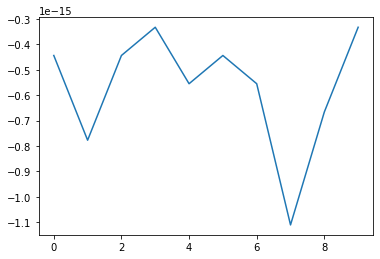

In [618]:
plt.plot(np.arange(0,N), explicit_polarization(toy_finite_hamiltonian(tanh_perturbation(N), N),N, max_e=0.9))

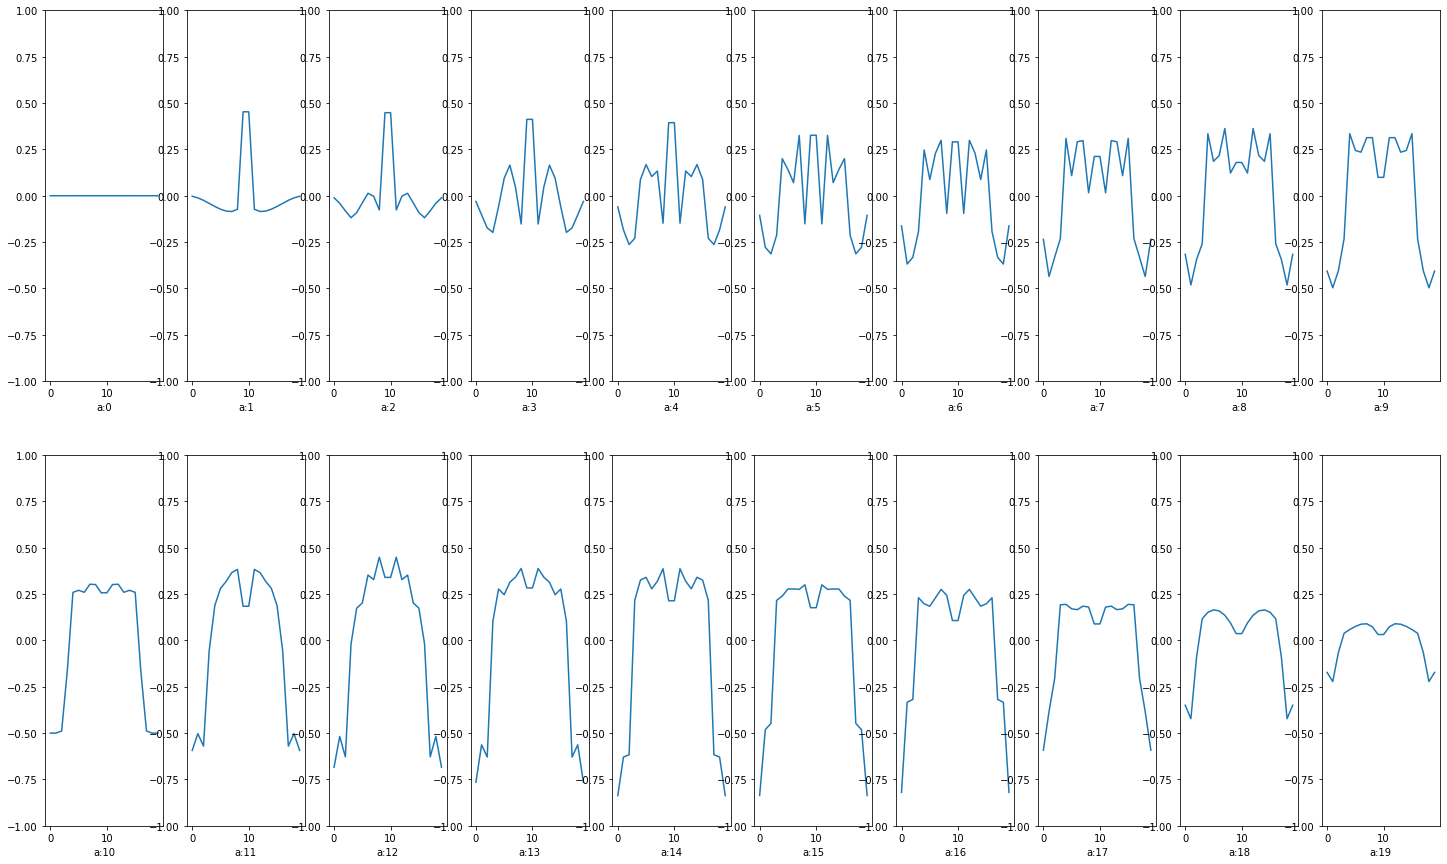

In [506]:
plot_perturbed_contribution(20,perturbation=tanh_perturbation(20),row_num=2)

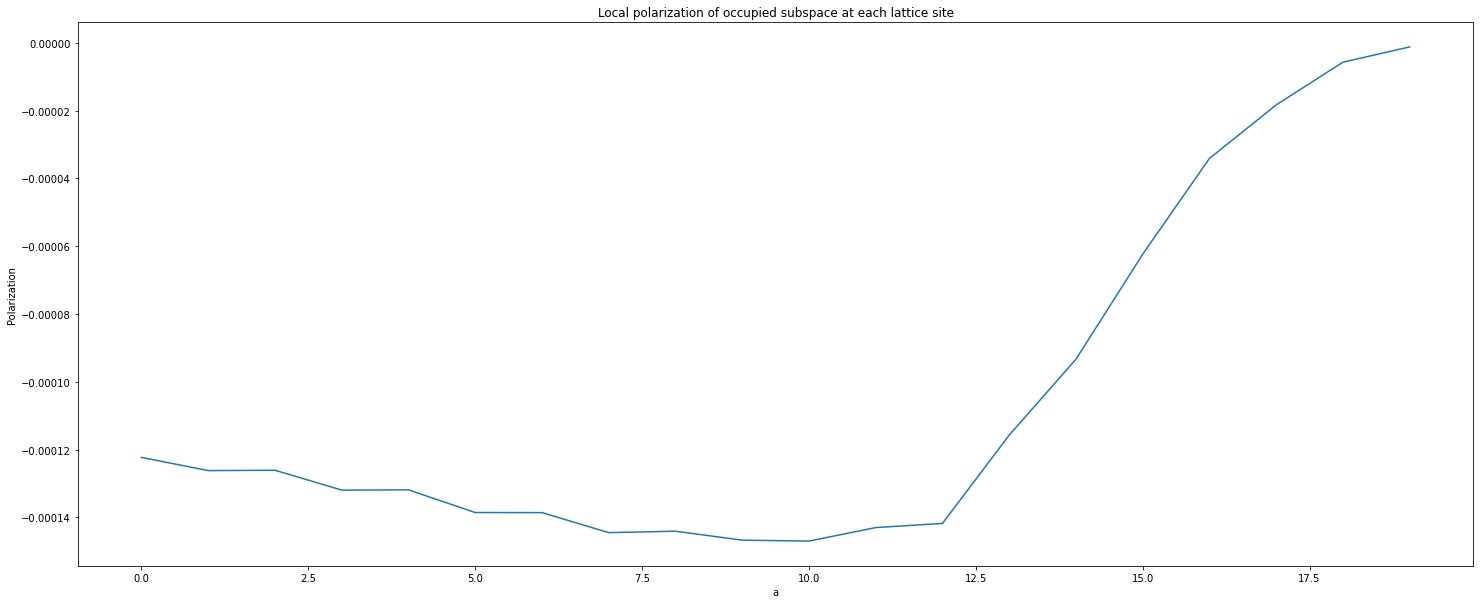

In [507]:
plot_perturbed_polarization(20, perturbation=tanh_perturbation(20))

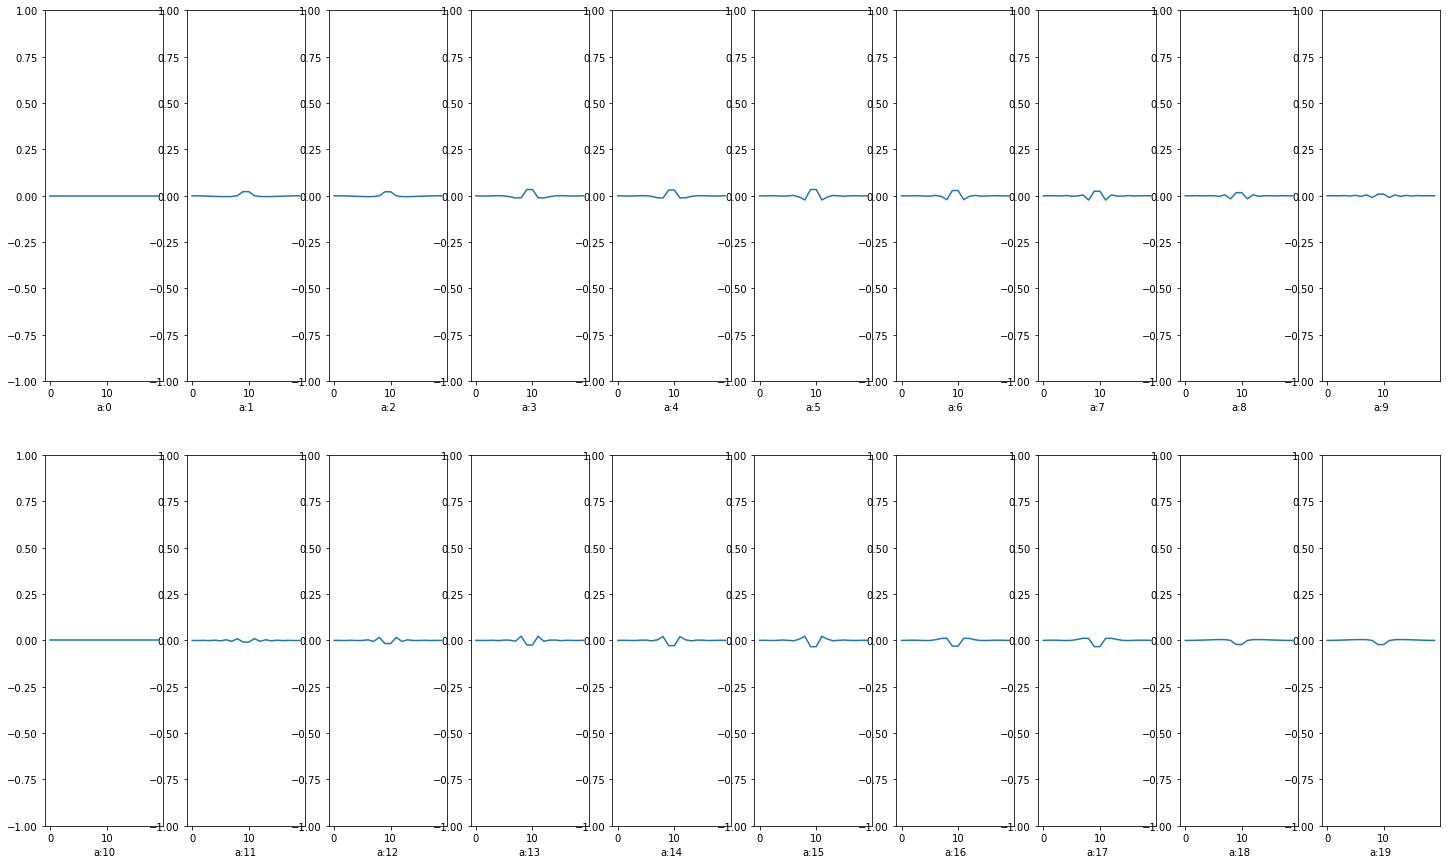

In [493]:
plot_perturbed_contribution(20)

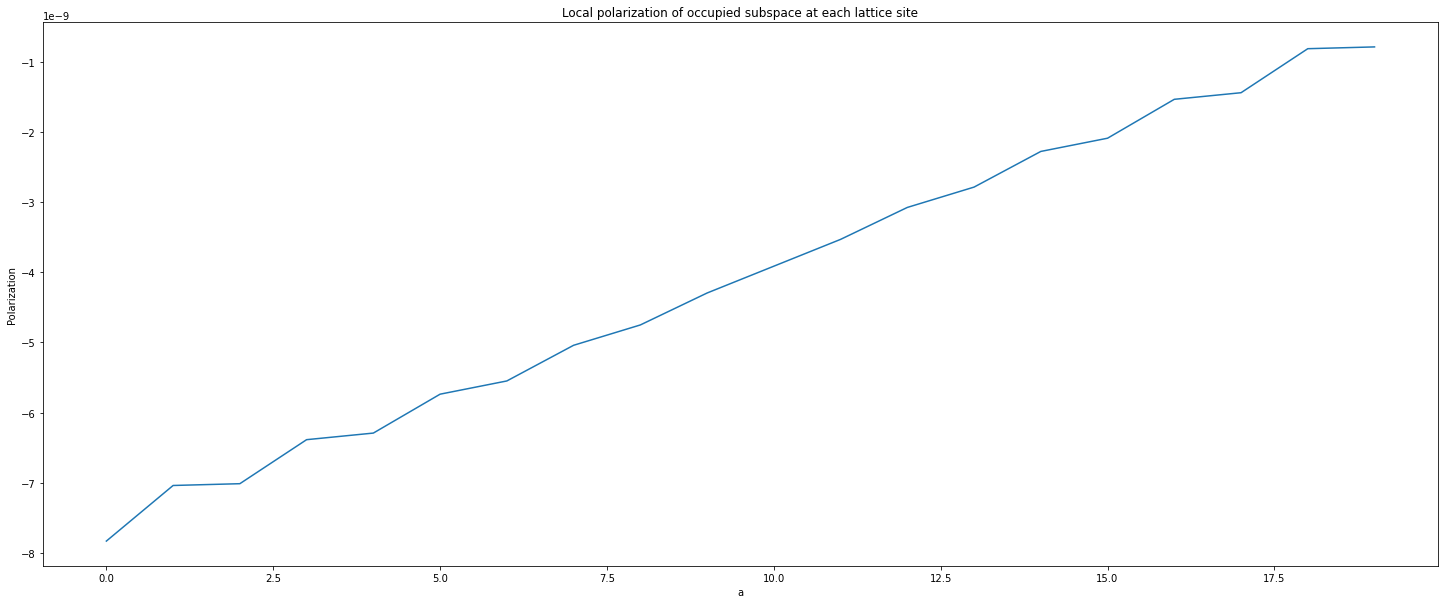

In [501]:
plot_perturbed_polarization(20)

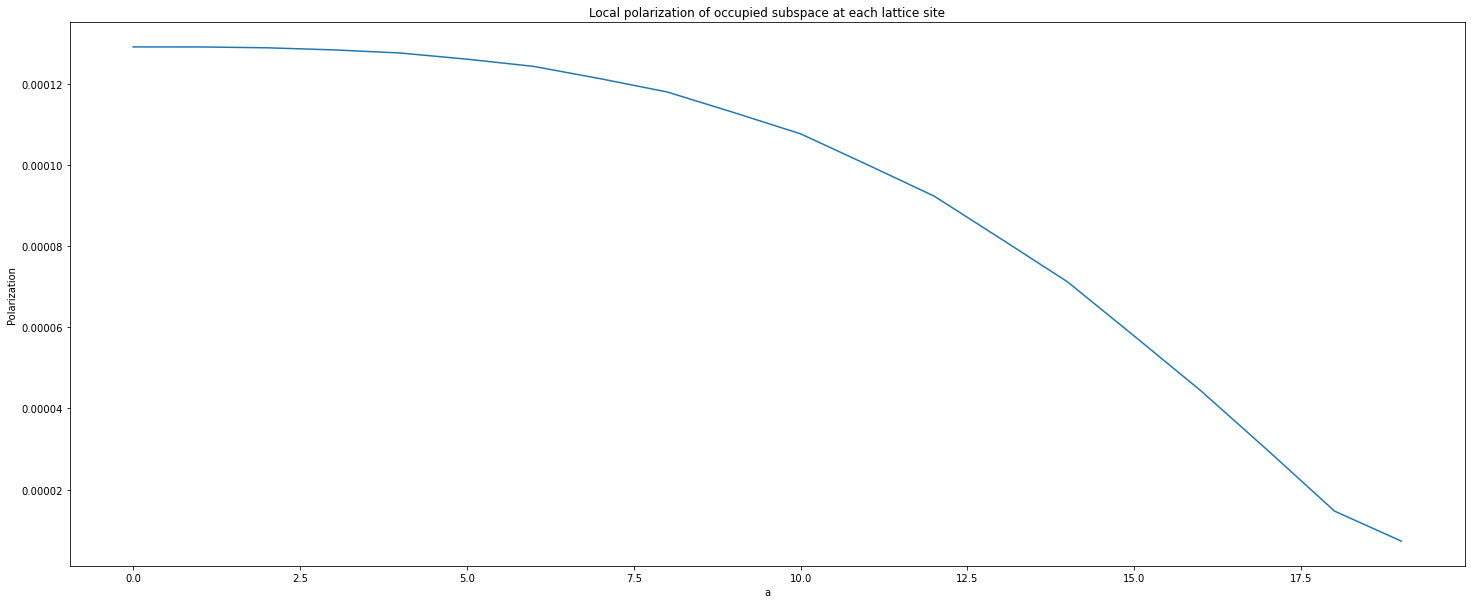

In [502]:
plot_perturbed_polarization(20, perturbation=linear_perturbation(20))

In [445]:
# Now if we wish to consider the change in polarization produced at a single lattice site a for different sizes of perturbations
def plot_lattice_polarization_change(N,a, max_e=0.9, steps=10, perturbation=None, row_num=2, col_num=10):
    if perturbation == None:
        perturbation = uniform_perturbation(N)
    
    plt.figure(figsize=(25,10))
    r = list(range(0,N))
    for i in range(0,steps):
        plt.subplot(row_num,col_num,i + 1)
        polarizations = np.sum(single_eig_current(toy_finite_hamiltonian(perturbation, N),a, timesteps=1000, max_e = max_e/steps * i), axis=0)
        plt.plot(r, polarizations)


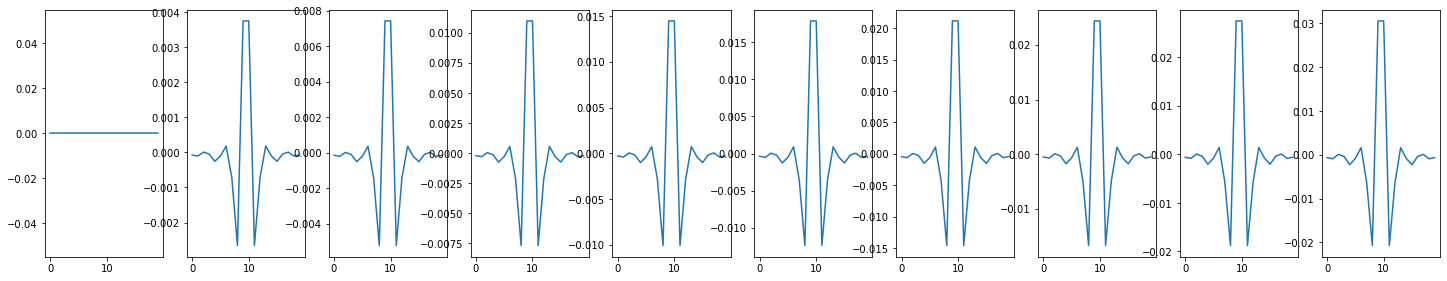

In [447]:
plot_lattice_polarization_change(30, 5, steps=10)

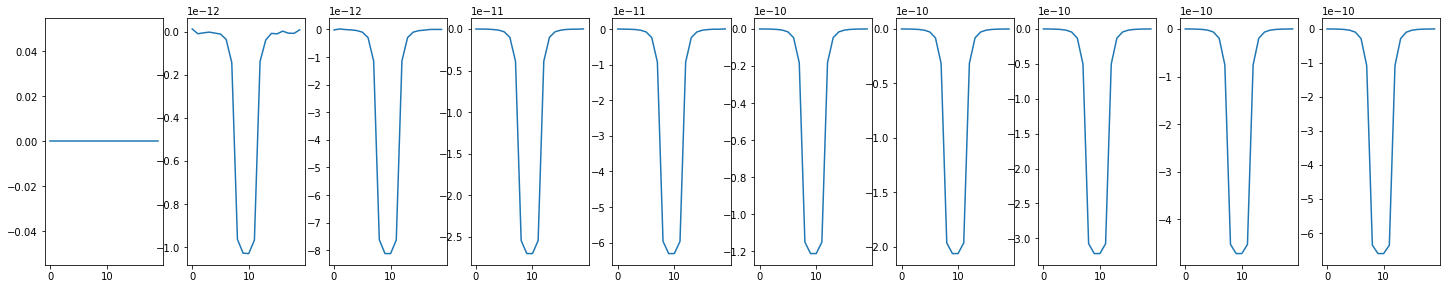

In [448]:
plot_lattice_polarization_change(30,10, steps=10)

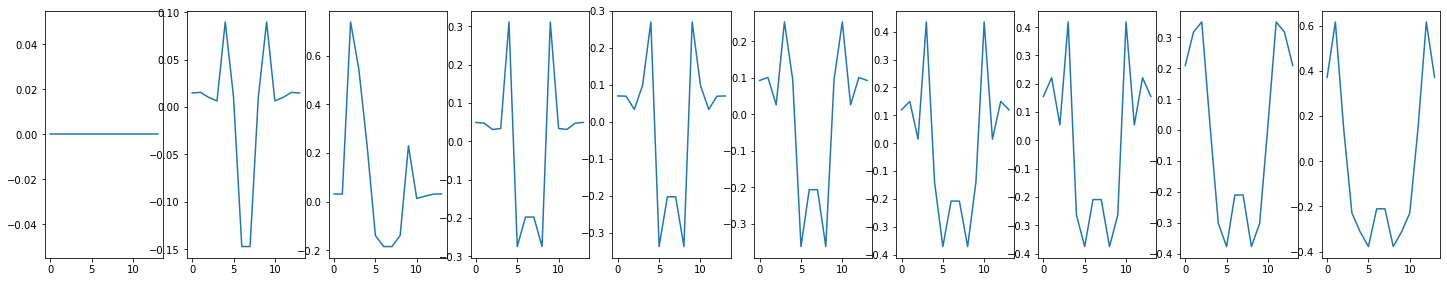

In [463]:
plot_lattice_polarization_change(14,10, steps=10, perturbation=tanh_perturbation(14))

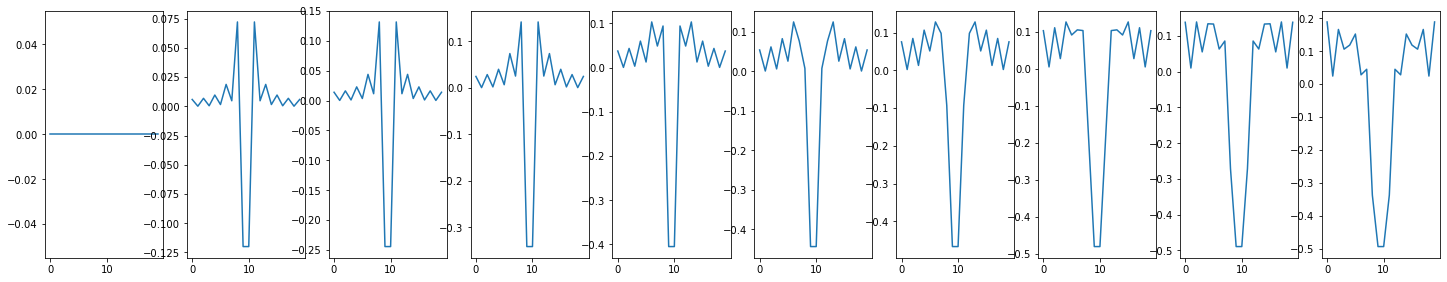

In [451]:
plot_lattice_polarization_change(20, 10, steps=10, perturbation=linear_perturbation(20))